### Purpose of this notebook:

- data exploration and visualization

In [1]:
import requests
import os
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import time
from joblib import delayed, Parallel
import datetime
# helper functions:
import helpers
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%matplotlib inline

In [2]:
data = pd.read_csv('openFDA_data/data/combined_weekly_sample_20200514.csv');

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13,15,17,21,28,36,40,45,58) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Let's get a sense of the sample data:

- The sample of data we pulled has 63800 rows and 85 columns, with event dates ranging from January 2010 to March 2020. Note: the total data set consists of over 1.2 million records, so the data we are working with here is only a small representation of the complete picture

- There are quite a few columns with incomplete data, we'll need to do some data QC to select more useful features

- While some data is not missing, they may still be non-informative if e.g. there is only 1 unique value

In [3]:
data.shape

(53400, 85)

### What does the missingness situation look like? 

In here, 0 = not missing, 1 = missing

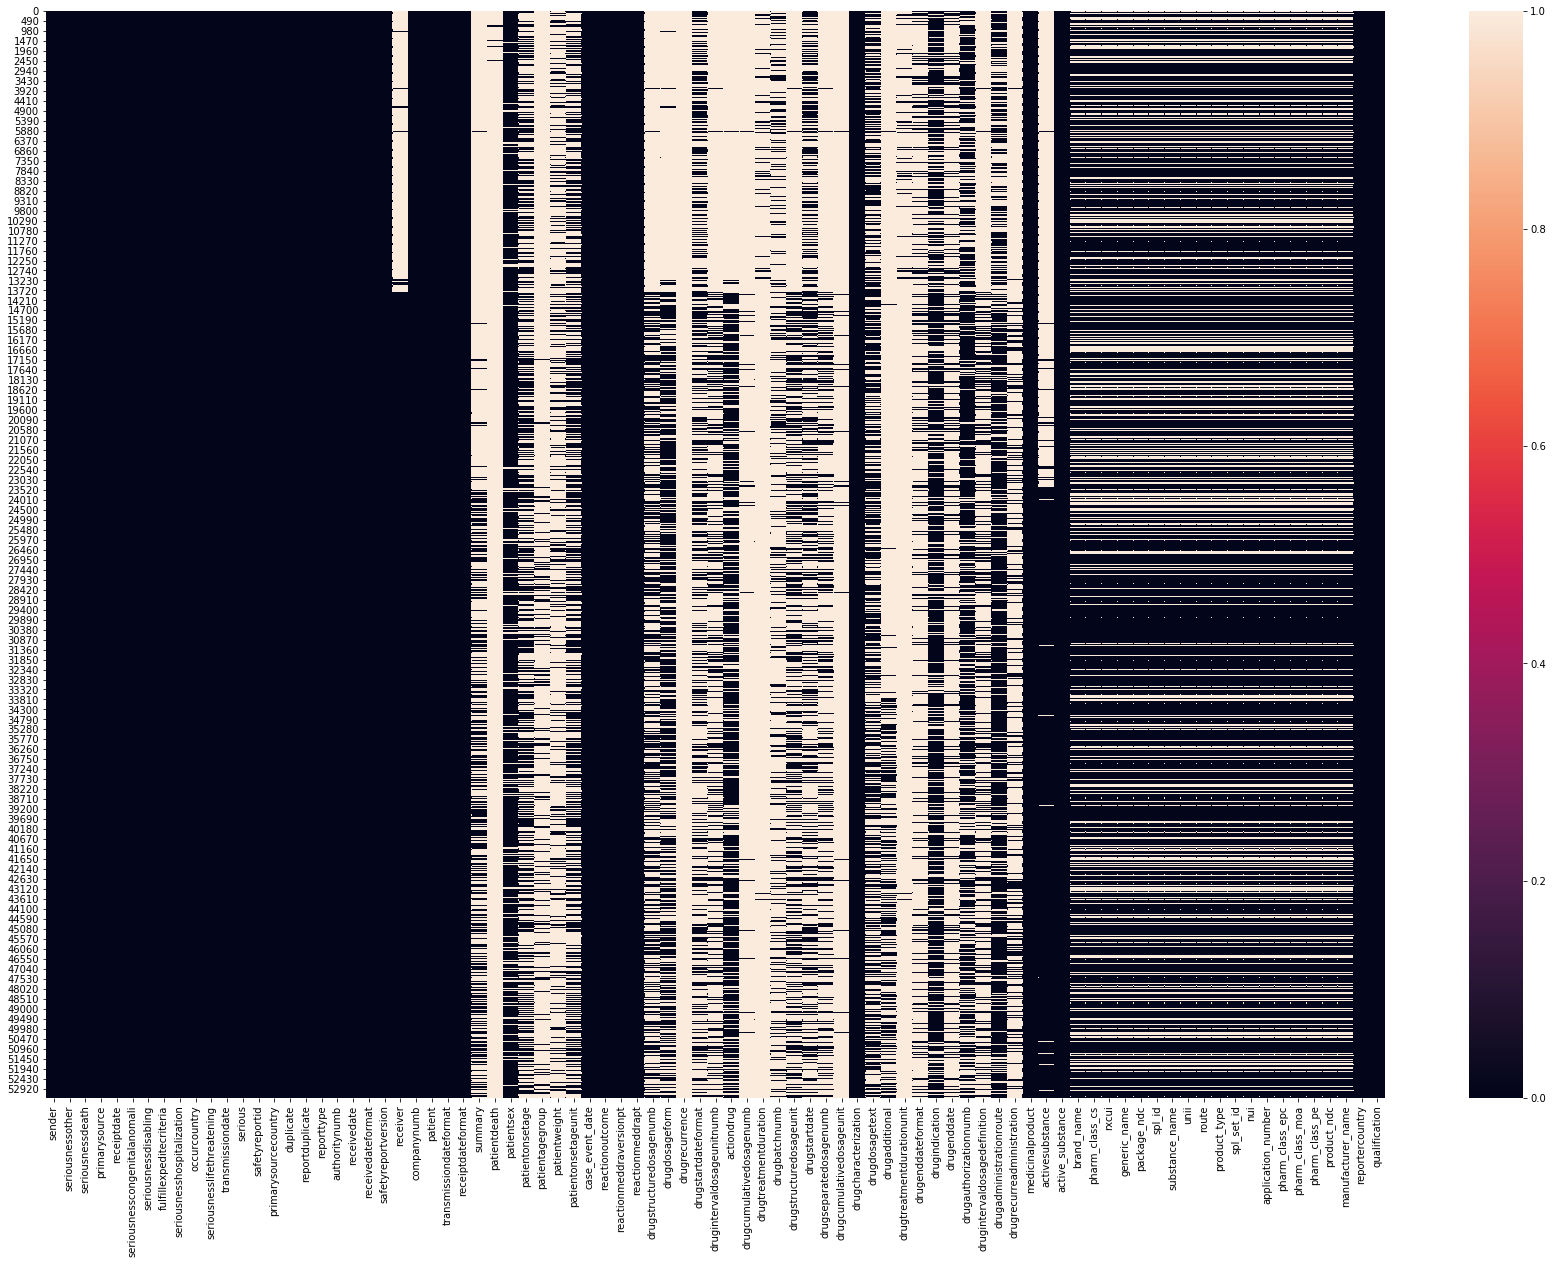

In [4]:
plt.figure(figsize=(30,20))
missing_data_count = sns.heatmap(data.isnull(), cbar = True)
plt.savefig('missing_data_count.png')
#sns.barplot(data_var)
#missing_data_count.savefig("missing_data_count.png")

### Below we can see how many unique values each feature has:

In [5]:
unique_levels = pd.DataFrame(data = {'column':data.columns,'nunique':data.nunique()}).sort_values('nunique')

#sns.barplot(unique_levels)

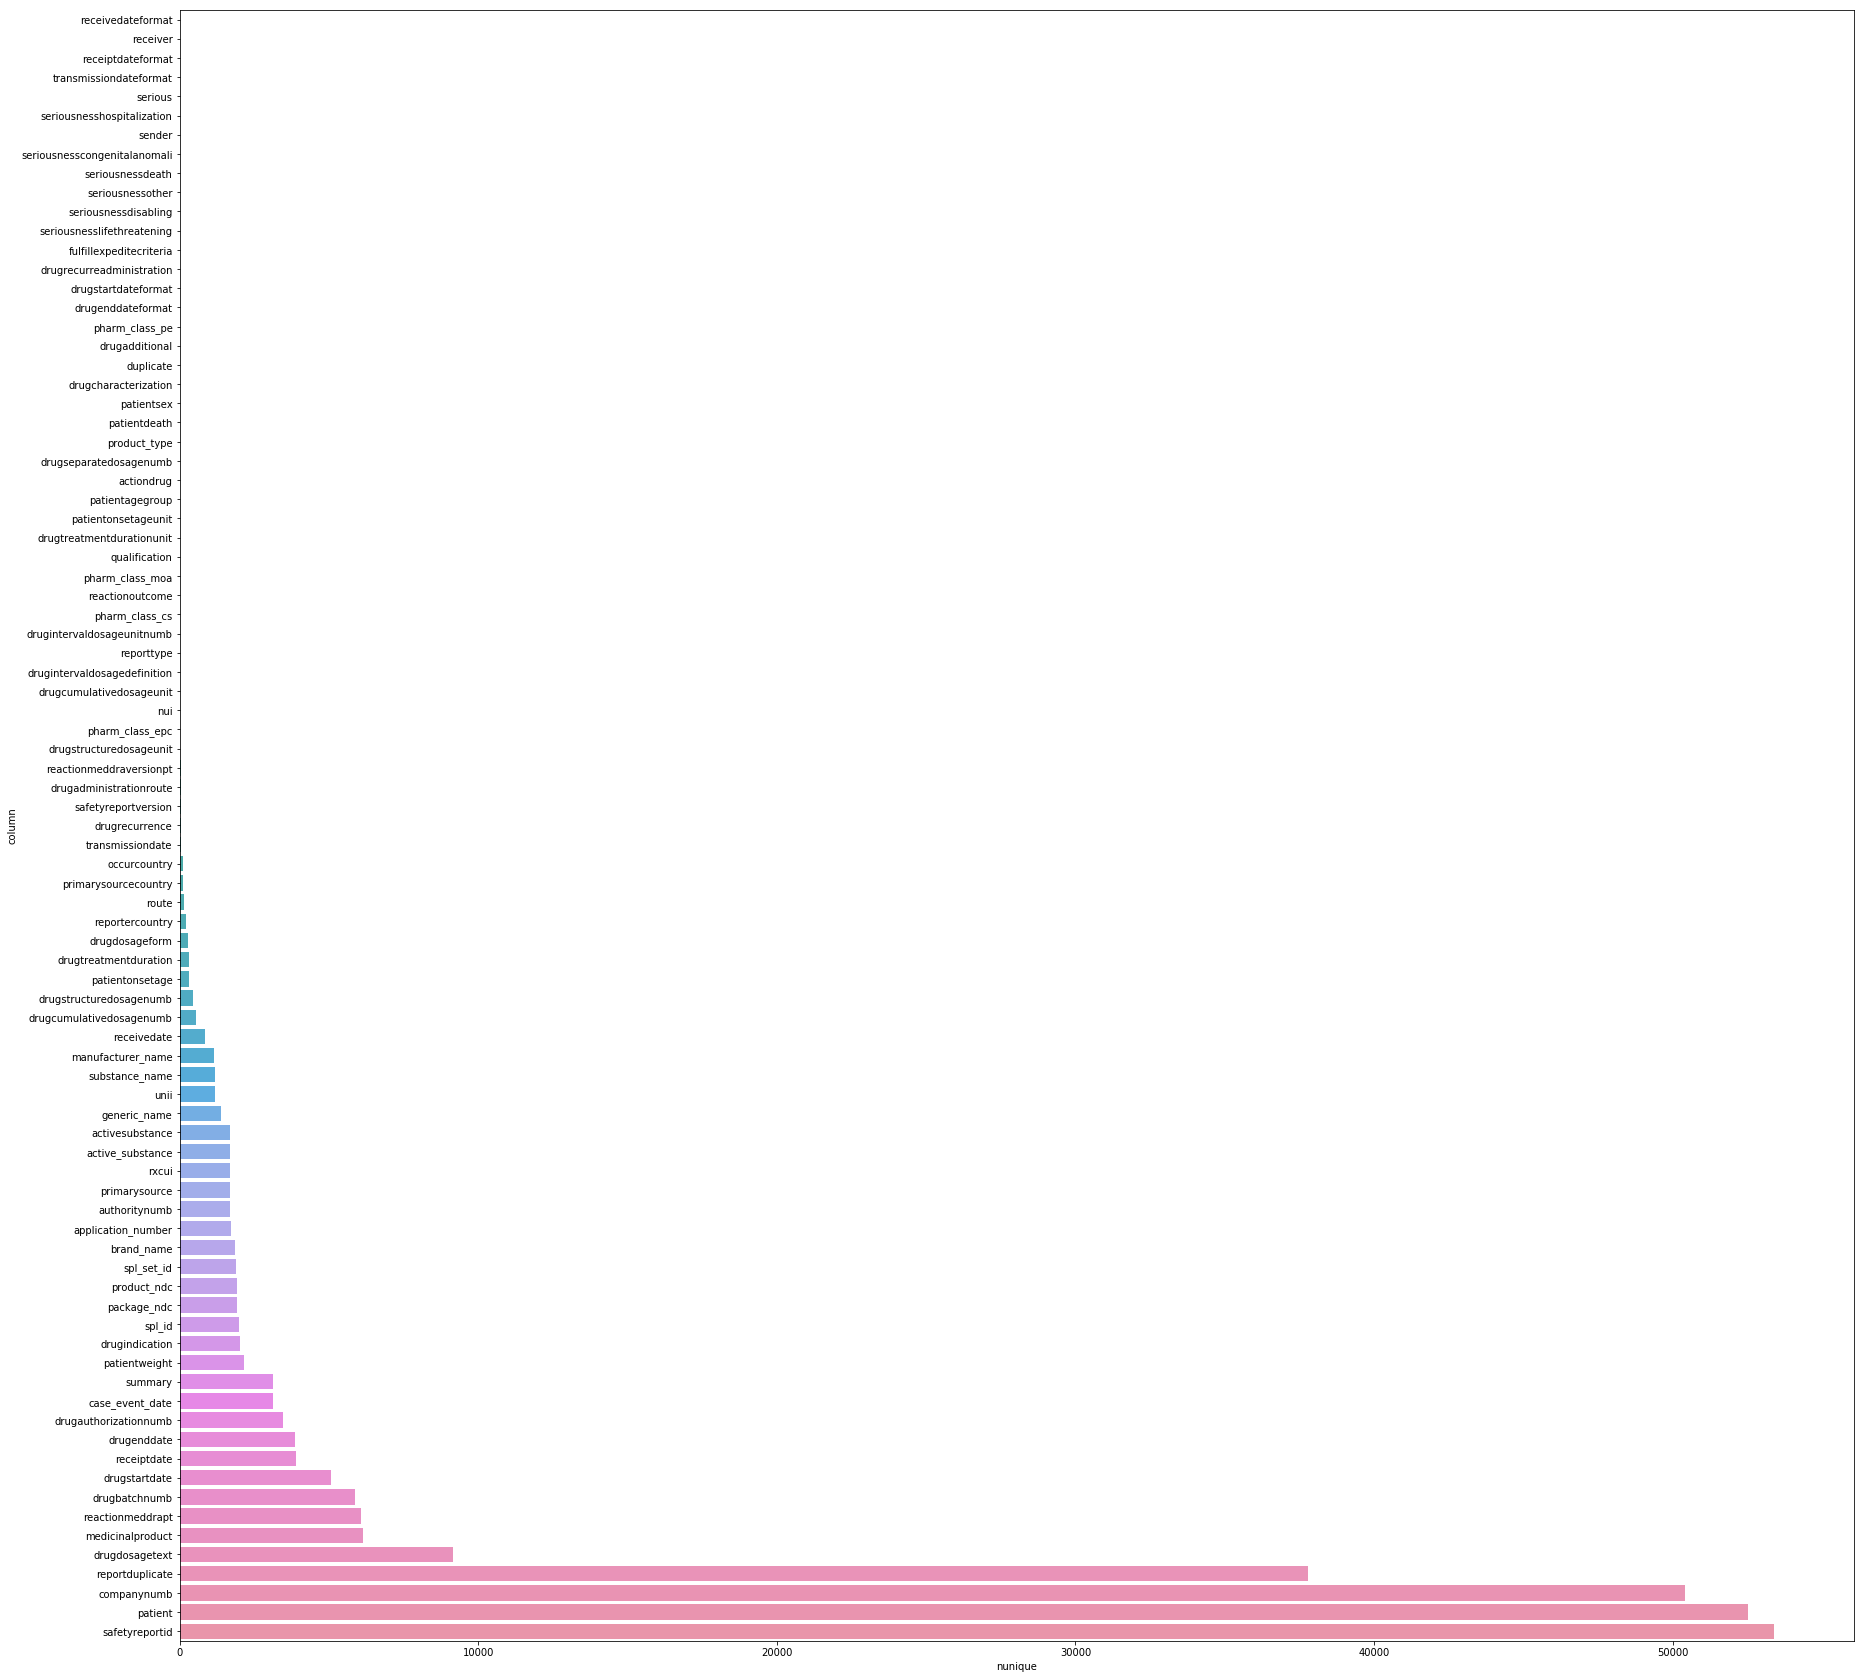

In [6]:
plt.figure(figsize=(30,30))
sns.barplot(data=unique_levels, y ='column', x='nunique')
plt.savefig('unique_levels.png')

### Now let's do a 'rough chop' for data cleaning:

Horizontal (column): by dropping a feature using the following criteria:

- % of missing data > 80%

- has only 1 unique level

- represents a nested key (those were already unested in the previous data gathering function so information should be contained in other columns)

Vertical (rows) : drop records using the following criteria:

- if patient's onset age is outside of the (0,120) range

In [7]:
missing_df = data.isnull()

missing_df_info = pd.DataFrame(data = {'missing_count':missing_df[missing_df==True].count(axis=0)/len(data)})


In [15]:
nested_keys = ['primarysource','sender','patient','receiver','reportduplicate','summary','patientdeath']
informative_vars1 = [val for val in set(missing_df_info[missing_df_info['missing_count']<0.8].index) - set(nested_keys) ]

In [16]:
informative_vars2 = [val for val in unique_levels[unique_levels['nunique']>1].index]

In [17]:
informative_vars = [val for val in informative_vars1  or informative_vars2]

len(informative_vars)

70

In [18]:
data_subset = data[informative_vars][(data['patientonsetage']<120) & (data['patientonsetage'])>0]

data_subset.shape

(27380, 70)

In [12]:
### Let's take a look at the variables that got removed:

In [19]:
set(data.columns) - set(informative_vars)

{'drugadditional',
 'drugcumulativedosagenumb',
 'drugcumulativedosageunit',
 'drugrecurreadministration',
 'drugrecurrence',
 'drugtreatmentduration',
 'drugtreatmentdurationunit',
 'patient',
 'patientagegroup',
 'patientdeath',
 'primarysource',
 'receiver',
 'reportduplicate',
 'sender',
 'summary'}

### Now some data analysis to answer the following questions based on the sample of data:

- What types of adverse events are there?
- Are different adverse events associated with different countries, or different disease areas?


From the metadata, we know that the flag `serious` indicates whether or not the adverse events result in serious conditions which are: death, a life threatening condition, hospitalization, disability, congenital anomaly, and other



